
## Advanced Lane Localization 


The steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


Step 0: Import all necessary libraries

In [2]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from moviepy.editor import VideoFileClip
import glob
%matplotlib inline

Step 1:
Find corresponding corners from the checkerboard images, compute object points and image points

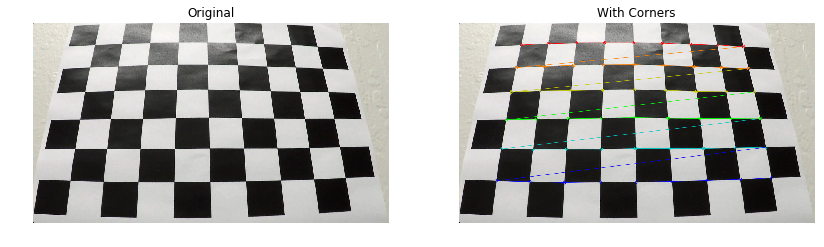

In [3]:
def find_corners(img, display=False):

    nx, ny = 9, 6

    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    img0 = np.copy(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    # Arrays to store object points and image points from all the images.
    obj_points = [] # 3d points in real world space
    img_points = [] # 2d points in image plane.

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret:
        obj_points.append(objp)
        img_points.append(corners)

    if display:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
        ax1.imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=12)
        ax1.set_axis_off()
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('With Corners', fontsize=12)
        ax2.set_axis_off()
        
    else:
        return obj_points, img_points

find_corners(cv2.imread('cam_calib/calibration3.jpg'), True)

Step 3: Undistort camera images using opencv functions

In [4]:
# Remove distortion from images
def undistort(img, display=False):
    """
    Calibrate a camera image using cv2.undistort() function
    """
    img_size = (img.shape[1], img.shape[0])
    
    obj_points, img_points = find_corners(cv2.imread('cam_calib/calibration3.jpg'))
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    if display:
        f, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
        
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=12)
        ax1.set_axis_off()
        
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted', fontsize=12)
        ax2.set_axis_off()
        
    else:
        return undist

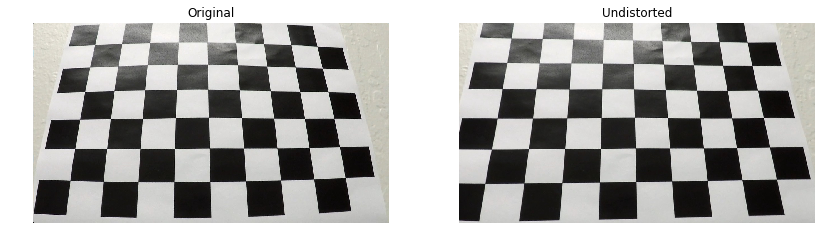

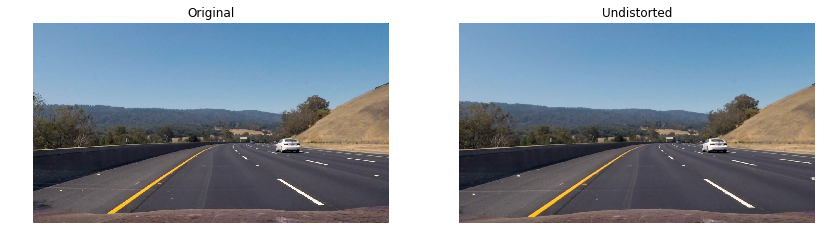

In [5]:
undistort(cv2.imread('cam_calib/calibration3.jpg'), True)
undistort(cv2.imread('test_images/test3.jpg'), True)

Step 4: Transform the front-view road images into top-down bird-view images for computing curvature of the lane

In [6]:
# Apply perspective transform
def perspective_warp(img, display=False):

    src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
    dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=12)
        ax1.set_axis_off()
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped', fontsize=12)
        ax2.set_axis_off()
    else:
        return warped


# Reverse perspective transform
def perspective_unwarp(img, display=False):
    
    src = np.array([[585, 460], [203, 720], [1127, 720], [695, 460]]).astype(np.float32)
    dst = np.array([[320, 0], [320, 720], [960, 720], [960, 0]]).astype(np.float32)
    
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    unwarped = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]))
    
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=12)
        ax1.set_axis_off()
        ax2.imshow(cv2.cvtColor(unwarped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Unwarped', fontsize=12)
        ax2.set_axis_off()
    else:
        return unwarped

Step 5: Extract lane lines using gradients by sobel filters 

In [7]:
# Apply a threshold on the sobel magnitude
def sobel_threshold(img, kernel=3, thresh=(20, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    # Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    # Rescale to 8 bit
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag / scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    grad_binary = np.zeros_like(grad_mag)
    grad_binary[(grad_mag >= thresh[0]) & (grad_mag <= thresh[1])] = 1
    
    return grad_binary


Step 6: Extract lane lines using color thresholding in HLS space

In [8]:
def color_threshold(img, display=False, tune_param=False):
    '''
    Apply color thresholding to locate lane lines
    '''
    
    warped = perspective_warp(img)

    L = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)[:,:,1]
    S = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)[:,:,2]

    s_thresh = (160, 250)
    s_binary = np.zeros_like(S)
    s_binary[(s_thresh[0] < S) & (S <= s_thresh[1])] = 1
    
    l_thresh = (220, 255)
    l_binary = np.zeros_like(L)
    l_binary[(l_thresh[0] < L) & (L <= l_thresh[1])] = 1

    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary==1) | (l_binary==1)] = 1
    
    if tune_param:
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(14,4))

        ax1.set_title('S binary', fontsize=12)
        ax1.imshow(s_binary, cmap='gray')
        ax1.set_axis_off()
        
        ax2.set_title('L binary', fontsize=12)
        ax2.imshow(l_binary, cmap='gray')
        ax2.set_axis_off()

    if display:
        # Plotting thresholded images
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
        f.tight_layout()
        
        ax1.set_title('Original', fontsize=12)
        ax1.imshow(cv2.cvtColor(undistort(img, False),cv2.COLOR_BGR2RGB))
        ax1.set_axis_off()
        
        ax2.set_title('Warped', fontsize=12)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB).astype('uint8'))
        ax2.set_axis_off()
        
        ax3.set_title('Color Thresholded', fontsize=12)
        ax3.imshow(color_binary, cmap='gray')
        ax3.set_axis_off()

    if not (tune_param or display):
        return color_binary

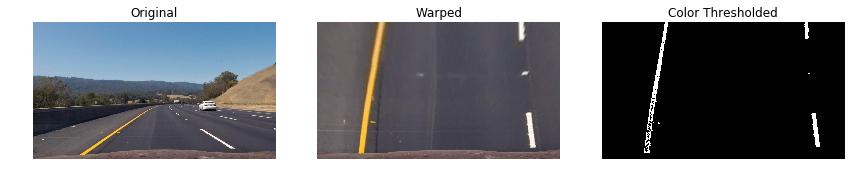

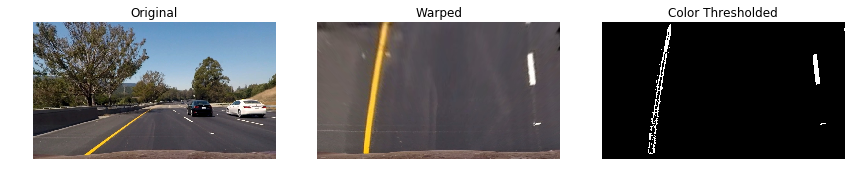

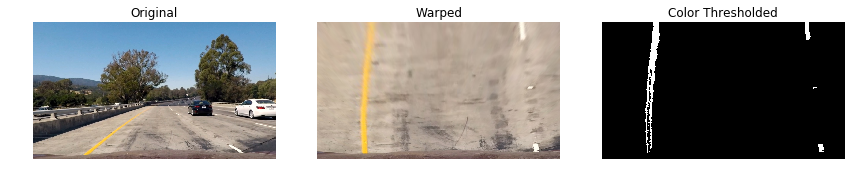

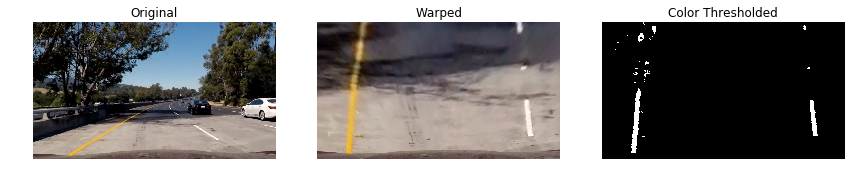

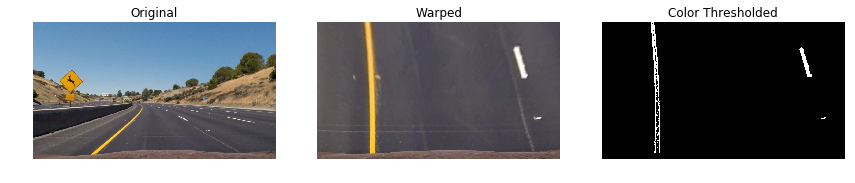

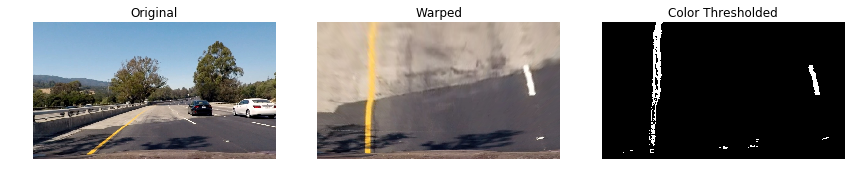

In [9]:
## Code for tuning color thresholds
test_images = glob.glob('test_images/test*.jpg')
for fname in test_images:
    color_threshold(cv2.imread(fname), True)

Step 7: Combine color and gradient thresholded masks into final lane line binary images

In [10]:
# Applies the HLS and sobel masks to the image
def find_lanes_binary(img):
    img = img.copy()
    
    # Apply a mask on HLS colour channels
    # This selects pixels with higher than 100 saturation and lower than 100 hue
    color_mask = color_threshold(img)
    
    # Apply a sobel magnitude threshold
    # I apply a more lenient mag_thresh to the upper part of the transformed image, as this part is blurrier
    # and will therefore have smoother gradients.
    # On the bottom half, this selects pixels with >10 sobel magnitude, and on the top half, 
    # selects pixels with >35 sobel magnitude
    sobel_low = sobel_threshold(img,  3, (13, 250))
    sobel_high = sobel_threshold(img,  3, (38, 250))
    
    ht = sobel_low.shape[0]
    grad_mask = np.zeros_like(sobel_low)
    grad_mask[int(ht/2):, :] = sobel_low[int(ht/2):, :]
    grad_mask[:int(ht/2), :] = sobel_high[:int(ht/2), :]
    
    # Use the bitwise OR mask of both masks for the final mask
    final_mask = np.maximum(color_mask, grad_mask)

    # Return the transformed mask
    return final_mask

Step 8: Apply a sliding window to fit the lane lines using polynomial equations

In [11]:
# This applies the sliding window approach to find lane pixels, and then fits a polynomial to the found pixels.
def sliding_window_poly(final_mask, n_windows=10, margin=80):
    # n_windows: Number of windows to split sliding window into
    # margin: Number of pixels on each side horizontally to consider
    
    # Split the image vertically into windows, for analysis.
    
    nrows, ncols = final_mask.shape
    
    bottom_half = final_mask[-int(0.5* nrows):, :]

    left_peak = bottom_half[:, :int(0.5*ncols)].sum(axis=0).argmax()
    right_peak = bottom_half[:, int(0.5*ncols):].sum(axis=0).argmax() + 0.5*ncols
    
    
    windows = []

    px = int(final_mask.shape[0] / n_windows) # Pixels per window
    for i in range(n_windows):
        window = final_mask[i*px:(i+1)*px, :]
        windows.append(window)

    # Reverse the order of the windows, in order to work from the bottom up
    windows = windows[::-1]
    
    # Loop over windows, finding the lane centre within the margin.
    lefts = [left_peak]
    rights = [right_peak]
    
    left_px, left_py, right_px, right_py = [], [], [], []
    
    for i, window in enumerate(windows):
        offset = (n_windows-i-1)*px
        
        last_left = int(lefts[-1])
        last_right = int(rights[-1])
        
        # Only consider pixels within +-margin of last window location
        left_win = window.copy()
        left_win[:, :last_left-margin] = 0
        left_win[:, last_left+margin:] = 0
        
        right_win = window.copy()
        right_win[:, :last_right-margin] = 0
        right_win[:, last_right+margin:] = 0
        
        # Save the x, y pixel indexes for calculating the polynomial
        left_px.append(left_win.nonzero()[1])
        left_py.append(left_win.nonzero()[0] + offset)
        
        right_px.append(right_win.nonzero()[1])
        right_py.append(right_win.nonzero()[0] + offset)
    
    # Create x and y indice arrays for both lines
    left_px = np.concatenate(left_px)
    left_py = np.concatenate(left_py)
    right_px = np.concatenate(right_px)
    right_py = np.concatenate(right_py)
    
    # Fit the polynomials
    if left_py.size == 0 or left_px.size == 0:
        l_poly = None
    else:
        l_poly = np.polyfit(left_py, left_px, 2)
        
    if right_py.size == 0 or right_px.size == 0:
        r_poly = None
    else:    
        r_poly = np.polyfit(right_py, right_px, 2)
    
    return l_poly, r_poly

Step 9: Compute curvature of left and right lane lines

In [12]:
# Calculate the lane line curvature
def get_curvature(poly_left, poly_right, mask, xscale = 3.7/700, yscale = 30/720):
#     yscale = 30 / 720 # Real world metres per y pixel
#     xscale = 3.7 / 700 # Real world metres per x pixel
    
    # Convert polynomial to set of points for refitting
    ploty = np.linspace(0, mask.shape[0]-1, mask.shape[0])
    fitx_left = poly_left[0] * ploty ** 2 + poly_left[1] * ploty + poly_left[2]
    fitx_right = poly_right[0] * ploty ** 2 + poly_right[1] * ploty + poly_right[2]
    
    # Fit new polynomial
    fit_cr_left = np.polyfit(ploty * yscale, fitx_left * xscale, 2)
    fit_cr_right = np.polyfit(ploty * yscale, fitx_right * xscale, 2)
    
    # Calculate curve radius
    coeff = np.max(ploty) * yscale
    rad_left = ((1 + (2 * fit_cr_left[0] * coeff + fit_cr_left[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr_left[0])
    rad_right = ((1 + (2 * fit_cr_right[0] * coeff + fit_cr_right[1]) ** 2) ** 1.5) / np.absolute(2 * fit_cr_right[0])
    
    return rad_left, rad_right

Step 10: Plot detected lanes on original image

In [13]:
# Plot the polygons on the image
def mark_lane_on_image(fit_left, fit_right, img, display=False):
    # Draw lines from polynomials
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    fit_left = fit_left[0]*ploty**2 + fit_left[1]*ploty + fit_left[2]
    fit_right = fit_right[0]*ploty**2 + fit_right[1]*ploty + fit_right[2]
    
    pts_left = np.array([np.transpose(np.vstack([fit_left, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([fit_right, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Create an overlay from the lane lines
    filled_lane = np.zeros_like(img).astype(np.uint8)
    cv2.fillPoly(filled_lane, np.int_([pts]), (0,255, 0))
    
    # Apply inverse transform to the overlay to plot it on the original road
    filled_lane = perspective_unwarp(filled_lane)
    
    # Add the overlay to the original unwarped image
    result = cv2.addWeighted(img, 1, filled_lane, 0.3, 0)
    
    if display:
        # Plotting thresholded images
        plt.imshow(result, cv2.COLOR_BGR2RGB)
        plt.title('Image with lanes filled', fontsize=12)
        plt.axis('off')
    else:
        return result

Step 11: Compute offset of the vehicle

In [14]:
# Find the offset of the car and the base of the lane lines
def find_offset(l_poly, r_poly, lane_width =3.7, h=720, w=1280):
#     lane_width = 3.7  # metres
#     h = 720  # height of image (index of image bottom)
#     w = 1280 # width of image
    
    # Find the bottom pixel of the lane lines
    l_px = l_poly[0] * h ** 2 + l_poly[1] * h + l_poly[2]
    r_px = r_poly[0] * h ** 2 + r_poly[1] * h + r_poly[2]
    
    # Find the number of pixels per real metre
    scale = lane_width / np.abs(l_px - r_px)
    
    # Find the midpoint
    middle = np.mean([l_px, r_px])
    
    # Find the offset from the centre of the frame, and then multiply by scale
    offset = (w/2 - middle) * scale
    return offset

### Main pipeline for end-to-end lane line detection

In [15]:
# Function to apply to frames of video
def main_pipeline(img):
    
    
    # Undistort the image using the camera calibration
    img = undistort(img)
    
    # Keep the untransformed image for later
    frame = img.copy()
    
    # Apply perspective transform to the image
    img = perspective_warp(img)
    
    # Apply the gadient and color mask to detect lane pixels
    lane_binary = find_lanes_binary(img)
    

    # Get the sliding window polynomials for each line line
    l_poly, r_poly = sliding_window_poly(lane_binary)
    
        
    # Calculate the lane curvature radius
    l_rad, r_rad = get_curvature(l_poly, r_poly, lane_binary)
    
    # Create image
    final = mark_lane_on_image(l_poly, r_poly, frame)
    
    # Get mean of curvatures
    rad = (l_rad + r_rad)/2
    
    offset = find_offset(l_poly, r_poly)
        
    # Write radius on image
    cv2.putText(final, 'Lane Radius: {}m'.format(int(rad)), (300, 50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255,255,255),2)
    
    # Write lane offset on image
    cv2.putText(final, 'Lane Offset: {}m'.format(round(offset,4)), (300, 100), cv2.FONT_HERSHEY_COMPLEX, 1.5, (255,255,255),2)
    
    return final

In [26]:
output_file = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
vclip = clip1.fl_image(main_pipeline) 

%time vclip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_11.mp4
[MoviePy] Writing video project_11.mp4


100%|█████████▉| 1260/1261 [03:59<00:00,  5.23it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_11.mp4 

CPU times: user 8min 18s, sys: 14.8 s, total: 8min 33s
Wall time: 4min
